In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.io import savemat, loadmat
import matlab.engine # to run Cheng's code
import time

# add the path to my packages to system paths so they can be imported
import sys
sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages')
# sys.path.append('F:\MAScThesis\code\my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

import simgraph.my_simgraph_06 as sg
import dataprocess.data_handler_03 as dh

# Load and group neuron spike data

In [2]:
# load all spike data from file
spikes_dp = '../../data/original_files/spikes.csv'
binned_data = np.loadtxt(spikes_dp, delimiter=',')
binned_data = binned_data.reshape(binned_data.shape[0], 1141, 113)
binned_data = binned_data * 2 - 1     # turn labels from 0,1 to -1,1

In [3]:
binned_data.shape

(297, 1141, 113)

In [4]:
I_order_10 = [54, 35, 10, 60, 74, 9, 61, 56, 91, 104]

# group all neurons together
grouped_data = np.zeros((297, 1141, 1))
for trial in range(297):
    for frame in range(1141):
        grouped_data[trial, frame, :] = 2 * int((binned_data[trial, frame, :] == 1).any()) - 1

# Create training and validation datasets

In [13]:
def get_mnist_labels(data_params):
    return np.loadtxt(data_params['features_dp']+'lbls.csv')

def transform_mnistsift(fv):
    return fv[::4]

def transform_slowfast(fv):
    """
    Transform to be applied on feature vectors.
    
    Input: fv
    fv - 1xDf torch tensor representing a feature vector
    
    Output: fvv
    fvv - 1xDf' torch tensor representing the transformed feature vector
    """
    
    # for faster run and less memory usage
    fvv = fv[::200]
    
    # for numerical stability during GD
    # fvv = fvv * 10
    
    return fvv

def transform_sift3d(fv):
    return fv[::10]

def transform_parham(fv):
    return fv[::5]

# data retrieval params
# data_params = {'func': dh.datapoint_sift, 'lbl_func': get_mnist_labels, 'features_dp': '../../data/fe_exp/mnist-sift/', \
#                'spike_data': None, 'group_id': None, 'transform': transform_mnistsift, 'ind_min': 0, 'ind_max': 13203, 'feature_id':'mnist-sift'}

data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/slowfast/slowfast_4732_numpy/', \
               'spike_data': grouped_data, 'group_id': 0, 'transform': transform_slowfast, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'slowfast'}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/sift3d/fvs_s1/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_sift3d, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'sift3d'}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/parham/parham3/features_2layer/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_parham, 'ind_min': 1*1141+41, 'ind_max': 2*1141-1, 'feature_id':'parham'}

In [14]:
train_num = 20
val_num = 100

# # # load all the labels
# # data_path = '../../data/fe_exp/mnist-sift/'
# # lbls = np.loadtxt(data_path+'lbls.csv')

# def transform_mnistsift(fv):
#     return fv[::4]

# def get_mnist_labels(data_params):
#     return np.loadtxt(data_params['features_dp']+'lbls.csv')

# data_params = {'func': dh.datapoint_sift, 'lbl_func': get_mnist_labels, 'features_dp': '../../data/fe_exp/mnist-sift/', \
#                'spike_data': None, 'group_id': None, 'transform': transform_mnistsift, 'ind_min': 0, 'ind_max': 13203, 'feature_id':'mnist-sift'}

train_num, val_num, train_data, val_data = \
dh.random_train_val_balanced(train_num, val_num, data_params, seed=0)

# optional normalization
train_data['des'] = dh.normalize(train_data['des'])
val_data['des'] = dh.normalize(val_data['des'])

# show statistics
print('feature_id: ', data_params['feature_id'])
print('train_num = ', train_num, ', val_num = ', val_num)
print('number of features: ', train_data['des'].shape[1])
print('training data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(train_data['lbls'] == 1), np.sum(train_data['lbls'] == 1)*100/train_num))
print('validation data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(val_data['lbls'] == 1), np.sum(val_data['lbls'] == 1)*100/val_num))

# print('train_smpls = ', train_data['smpls'], '\nval_smpls = ', val_data['smpls'])
# print('train_lbls = ', train_data['lbls'], '\nval_lbls = ', val_data['lbls'])
# print('train_des = ', train_data['des'], '\nval_des = ', val_data['des'])

feature_id:  slowfast
train_num =  20 , val_num =  100
number of features:  24
training data contains 10 points (50.00%) of label 1.
validation data contains 50 points (50.00%) of label 1.


# Set parameters

In [15]:
# visualize the learned metric matrix
def visualize_M(M, fig_params):
    # unpack params
    rmark_th = fig_params['rmark_th']
    xloc = fig_params['xloc']
    yloc = fig_params['yloc']

    sg.display_matrix(M, None)
    # mark prominent elements          
    lim = (rmark_th/100) * np.max(M) # marker threshold                
    plt.plot(xloc[M > lim],yloc[M > lim], marker='o', markersize=3, color='r', linestyle='')
    plt.title('M - marked above {}%'.format(rmark_th))

In [16]:
# graph construction parameters (common for all three methods)
sg_params = {'Dt': 10, 'Dv':10, 'Dvt':20, \
             'cnstr_method_tt': 'halftime-lmnn', 'cnstr_method_vv': 'time-obj1', 'cnstr_method_vt': 'time',\
             'train_t': None, 'val_t': None, \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters (only used for factobj1)
gd_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 2, \
                'num_its':500, 'check_freq':10, 'print_checks':True, 'Theta0':None, \
                'force_all_its': True, 'threshold': -1}

# objective parameters (for both lmnn and obj1)
gamma = 1
beta = 1
sg_params['mu'] = 10 #factobj1 requires this objective parameter to be part of the sg_params dict

# random parameter for edge selection and B initialization
seed = 0

# swap path for matlab's use
swap_path_jupyter = '../../data/fe_exp/cheng_swap_1/' # relative to this notebook's current location
swap_path_matlab  = '../../../data/fe_exp/cheng_swap_1/' # relative to the matlab's folder, not this notebook's current location

In [17]:
# parameters to visualize the optimized M
f_sz = train_data['des'].shape[1] # must match data_params
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
fig_params = {'rmark_th': 5, 'f_sz': f_sz, 'xloc': xloc, 'yloc': yloc}

In [18]:
# update sg_params
sg_params['train_t'] = train_data['smpls']
sg_params['val_t'] = val_data['smpls']

# set edges
sg_params['edges_tt'] = sg.get_edges_tt(train_data['lbls'], sg_params['Dt'], sg_params['cnstr_method_tt'], sg_params['train_t'], seed)

In [19]:
len(sg_params['edges_tt'])

97

In [20]:
# save the dataset on disc for matlab's use
idstr = 'comparison_08'
savemat(swap_path_jupyter+'data_'+idstr+'.mat', {'data_feature': train_data['des'], 'data_label': train_data['lbls'], 'data_edge': sg_params['edges_tt']})
print('-> Iteration ID: ', idstr)

-> Iteration ID:  comparison_08


# Training
## CVX-LMNN

In [21]:
# eng.quit()

In [22]:
# start the matlab engine
eng = matlab.engine.start_matlab()

In [23]:
eng.cd(r'../15_cheng/lmnn-offtheshelf/', nargout=0)

In [14]:
# fit the graph
time0 = time.time()
(cvx_M, cvx_delta, cvx_status) = eng.lmnn_cvx_python(swap_path_matlab, idstr, gamma, beta, nargout=3)

Elapsed time is 0.135929 seconds.
Elapsed time is 0.097807 seconds.
n_delta = 15000
Elapsed time is 0.244404 seconds.
 
Calling SeDuMi 1.3.4: 32080 variables, 15000 equality constraints
------------------------------------------------------------
SeDuMi 1.3.4 by AdvOL, 2005-2008 and Jos F. Sturm, 1998-2003.
Alg = 2: xz-corrector, Adaptive Step-Differentiation, theta = 0.250, beta = 0.500


EngineError: MATLAB function cannot be evaluated

cvx_status:  Solved
Elapsed  time: 86.784103 sec


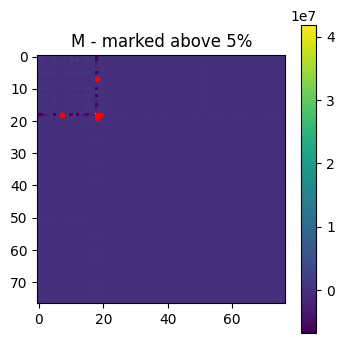

In [19]:
print('cvx_status: ', cvx_status)
cvx_M = np.array(cvx_M)
cvx_delta = np.array(cvx_delta).reshape(-1)
print('Elapsed  time: {:.6f} sec'.format(time.time()-time0))
visualize_M(cvx_M, fig_params)

In [20]:
# compute the objective matrix required to compute the training loss
cvx_V = eng.get_objective_variables_ready_python(swap_path_matlab, idstr)
cvx_V = np.array(cvx_V)

In [21]:
cvx_V

array([[ 0.04132483,  0.04139413,  0.03459456, ..., -0.09248525,
         0.03879178,  0.17308389],
       [ 0.04139413,  0.04148952,  0.0324306 , ..., -0.09135734,
         0.03962292,  0.1745608 ],
       [ 0.03459456,  0.0324306 ,  0.21908416, ..., -0.187202  ,
        -0.03307097,  0.04336958],
       ...,
       [-0.09248525, -0.09135734, -0.187202  , ...,  4.3307657 ,
         2.00356212, -0.03806085],
       [ 0.03879178,  0.03962292, -0.03307097, ...,  2.00356212,
         3.38321647,  1.71624055],
       [ 0.17308389,  0.1745608 ,  0.04336958, ..., -0.03806085,
         1.71624055,  4.40056954]])

## GDPA-LMNN

In [24]:
# change matlab's folder
eng.cd(r'../lmnn-gdpa-2/', nargout=0)

starting SGML.
initial objective value = Inf
1: objective_previous - objective_current = Inf
2: objective_previous - objective_current = 22.322153
3: objective_previous - objective_current = 8.452357
4: objective_previous - objective_current = 0.126262
5: objective_previous - objective_current = 0.000000
1: objective_previous - objective_current = 0.017623
2: objective_previous - objective_current = 0.000000
converged objective value = 136.4785
minimal eigenvalue of M = -0.0001
num_LP_rowcol = 240, num_LP_full = 2done with SGML.
Elapsed  time: 36.328026 sec


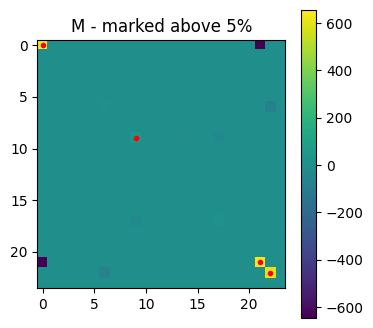

In [25]:
# fit the graph
time0 = time.time()
(gdpa_M, gdpa_delta, num_LP_rowcol, num_LP_full) = eng.lmnn_gdpa_python(swap_path_matlab, idstr, gamma, beta, nargout=4)
gdpa_M = np.array(gdpa_M)
gdpa_delta = np.array(gdpa_delta).reshape(-1)
print('Elapsed  time: {:.6f} sec'.format(time.time()-time0))
visualize_M(gdpa_M, fig_params)

In [26]:
# compute the objective matrix required to compute the training loss
gdpa_V = eng.get_objective_variables_ready_python(swap_path_matlab, idstr)
gdpa_V = np.array(gdpa_V)

# sanity check - V should be the same for both CVX and GDPA
assert (gdpa_V == cvx_V).all()

NameError: name 'cvx_V' is not defined

In [25]:
# close the matlab engine
eng.quit()

## Fact-GLR&trace

Number of training datapoints: 100
Number of features for each point: 77
mu = 10
   0: eps = 6.25e-02;  train loss (E) = 7781.76
  10: eps = 1.56e-02;  train loss (E) = 2062.29
  20: eps = 1.56e-02;  train loss (E) = 2057.32
  30: eps = 3.12e-02;  train loss (E) = 2056.70
  40: eps = 3.12e-02;  train loss (E) = 2056.59
  50: eps = 3.12e-02;  train loss (E) = 2056.56
  60: eps = 3.12e-02;  train loss (E) = 2056.54
  70: eps = 3.12e-02;  train loss (E) = 2056.54
  80: eps = 1.56e-02;  train loss (E) = 2056.54
  90: eps = 1.56e-02;  train loss (E) = 2056.54
  99: eps = 1.56e-02;  train loss (E) = 2056.54
Elapsed  time: 18.773129 sec


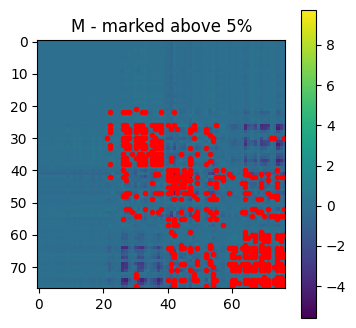

In [40]:
# fit the graph
time0 = time.time()
gd_opt_params['Theta0'] = None
fact_B, fact_stats = sg.fit_graph(train_data['des'], train_data['lbls'], sg_params, gd_opt_params, seed)
fact_M = fact_B.T @ fact_B
print('Elapsed  time: {:.6f} sec'.format(time.time()-time0))
visualize_M(fact_M, fig_params)

## LogReg

In [41]:
# instantiate the logistic regression model
lgrg = LogisticRegression(penalty='none', max_iter=1000000)
# fit model
lgrg = lgrg.fit(train_data['des'], train_data['lbls'])

# Validation

In [42]:
show_edges = False
# CVX-LMNN
cvx_val_acc, cvx_y_est, cvx_t = sg.get_acc(cvx_M, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'], sg_params, seed, show_edges)
# NOTE: sg_params['edges_vv'] and sg_params['edges_vt'] are fixed now
print('Elapsed time: {:.6f} sec'.format(cvx_t))
print('CVX-LMNN val. acc. = {:.2f}%'.format(cvx_val_acc*100))

Elapsed time: 0.110075 sec
CVX-LMNN val. acc. = 50.00%


In [43]:
# GDPA-LMNN
gdpa_val_acc, gdpa_y_est, gdpa_t = sg.get_acc(gdpa_M, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'], sg_params, seed, show_edges)
print('Elapsed time: {:.6f} sec'.format(gdpa_t))
print('GDPA-LMNN val. acc. = {:.2f}%'.format(gdpa_val_acc*100))

Elapsed time: 0.110527 sec
GDPA-LMNN val. acc. = 48.00%


In [44]:
# Fact-GLR&trace
fact_val_acc, fact_y_est, fact_t = sg.get_acc(fact_M, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'], sg_params, seed, show_edges)
print('Elapsed time: {:.6f} sec'.format(fact_t))
print('Fact-GLR&trace val. acc. = {:.2f}%'.format(fact_val_acc*100))

Elapsed time: 0.112962 sec
Fact-GLR&trace val. acc. = 61.00%


In [45]:
# LogReg
time0 = time.time()
lgrg_val_acc = lgrg.score(val_data['des'], val_data['lbls'])
lgrg_y_est = lgrg.predict(val_data['des'])
print('Elapsed time: {:.6f} sec'.format(time.time()-time0))
print('LogReg val. acc. = {:.2f}%'.format(lgrg_val_acc*100))

Elapsed time: 0.004907 sec
LogReg val. acc. = 71.00%


# Compare final loss values

In [29]:
# CVX-LMNN
cvx_loss = np.sum(cvx_M * cvx_V.T) + beta * np.sum(cvx_delta)
print('CVX-LMNN loss: {:.4f}'.format(cvx_loss))

In [30]:
# GDPA-LMNN
gdpa_loss = np.sum(gdpa_M * gdpa_V.T) + beta * np.sum(gdpa_delta)
print('GDPA-LMNN loss: {:.4f}'.format(gdpa_loss))

GDPA-LMNN loss: 136.4785


In [29]:
# Fact-GLR&trace
fact_loss = sg.cnstr_glr(fact_B, deriv=False, mu=sg_params['mu'], x=train_data['lbls'], F=train_data['des'].T, edges_tt=sg_params['edges_tt'])
print('Fact-GLR&trace loss: {:.4f}'.format(fact_loss))

NameError: name 'cvx_M' is not defined

## LMNN loss with Fact-GLR&trace optimized metric

In [33]:
edges_tt = np.array(sg_params['edges_tt'])
x = train_data['lbls']
feature = train_data['des']

In [34]:
e2 = 0
for edge_i in range(edges_tt.shape[0]):
    n_i = edges_tt[edge_i,0]
    n_j = edges_tt[edge_i,1]
    if x[n_i] == x[n_j]:
        n_ls = np.append(edges_tt[edges_tt[:,1] == n_i,0], edges_tt[edges_tt[:,0] == n_i,1], axis=0)
        for li in range(n_ls.shape[0]):
            if x[n_ls[li]] == -1*x[n_i]:
                f_ij = feature[n_i] - feature[n_j]
                f_il = feature[n_i] - feature[n_ls[li]]
                F_ijl = np.outer(f_ij, f_ij) - np.outer(f_il, f_il)
                temp = np.sum(fact_M * F_ijl) + gamma
                if temp >= 0:
                    e2 = e2 + temp

cvx_loss_with_fact = np.sum(fact_M * cvx_V.T) + beta * e2
print('CVX-LMNN loss with Fact-GLR&trace metric: {:.4f}'.format(cvx_loss_with_fact))

CVX-LMNN loss with Fact-GLR&trace metric: 1444.7015
